In [17]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import cv2
from sklearn.cluster import DBSCAN

In [18]:
def preprocess_images(image_folder, csv_file):
    images = []
    labels = []

    # Read the CSV file
    df = pd.read_csv(csv_file)

    for index, row in df.iterrows():  # iterate over each row in csv file
        filename = row['imagename'] #extract filename
        label = row['classlabel'] #extract label (0 or 1)

        image_path = os.path.join(image_folder, filename) #create a path to the image INSIDE folder
        if os.path.exists(image_path):
            image = Image.open(image_path) #open the image
            #image = image.resize((21, 21))  # Resize to 21x21 pixels
            image_array = np.array(image) #convert the image to array
            images.append(image_array) #add image to the "images" list
            labels.append(label) #add label to the "labels" list


    return np.array(images), np.array(labels) #returns the images and labels lists as np arrays

In [19]:
def preprocess_full_micrograph_csv(csv_file):

    # Read the CSV file
    df = pd.read_csv(csv_file)


    # Extract coordinates and convert to integers
    if 'X' in df.columns and 'Y' in df.columns:
        coordinates = df[['X', 'Y']].values.astype(int)
    else:
        raise KeyError("Columns 'X' and 'Y' not found in the CSV file.")

    return coordinates

In [20]:
class AtomDetectionCNN_ALT(nn.Module):
    def __init__(self):
        super(AtomDetectionCNN_ALT, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)  # First convolutional layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1) # Second convolutional layer
        self.adaptive_pool = nn.AdaptiveAvgPool2d((5, 5))                  # Adaptive pooling layer to output 5x5 feature maps
        self.fc1 = nn.Linear(64 * 5 * 5, 64)                               # Fully connected layer
        self.fc2 = nn.Linear(64, 1)                                        # Fully connected layer for binary classification

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.adaptive_pool(x)                                          # Apply adaptive pooling
        x = x.view(-1, 64 * 5 * 5)                                         # Flatten the feature maps
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))                                     # Sigmoid activation for binary classification
        return x

In [21]:
# Create a custom dataset to handle images and lables to train the model
class pt_atom_dataset(Dataset):
    def __init__(self, images, labels): # Initializes the dataset with images and labels.
        self.images = images
        self.labels = labels

    def __len__(self): # Returns the number of samples in the dataset
        return len(self.images)

    def __getitem__(self, idx): # Retrieves the image and label at the specified index (idx)

        return self.images[idx], self.labels[idx]

Preprocessing complete. Number of images: 2637
Epoch [1/25], Traning Loss: 0.6871, Validation Loss: 0.6867
Epoch [2/25], Traning Loss: 0.6873, Validation Loss: 0.6871
Epoch [3/25], Traning Loss: 0.6868, Validation Loss: 0.6867
Epoch [4/25], Traning Loss: 0.6872, Validation Loss: 0.6867
Epoch [5/25], Traning Loss: 0.6870, Validation Loss: 0.6866
Epoch [6/25], Traning Loss: 0.6862, Validation Loss: 0.6865
Epoch [7/25], Traning Loss: 0.6858, Validation Loss: 0.6879
Epoch [8/25], Traning Loss: 0.6859, Validation Loss: 0.6846
Epoch [9/25], Traning Loss: 0.6839, Validation Loss: 0.6833
Epoch [10/25], Traning Loss: 0.6828, Validation Loss: 0.6845
Epoch [11/25], Traning Loss: 0.6772, Validation Loss: 0.6707
Epoch [12/25], Traning Loss: 0.6582, Validation Loss: 0.6347
Epoch [13/25], Traning Loss: 0.6146, Validation Loss: 0.6234
Epoch [14/25], Traning Loss: 0.5445, Validation Loss: 0.4592
Epoch [15/25], Traning Loss: 0.4150, Validation Loss: 0.3396
Epoch [16/25], Traning Loss: 0.3283, Validation

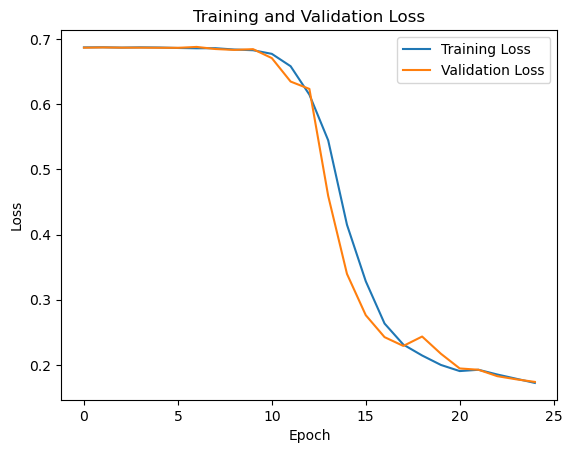

Model training complete, saved as 'best_model.pth'.


In [23]:
# Load and preprocess images
image_folder = '/home/uku/desktop/ML-C/Pt_data/Pt_data/training_crops'
csv_file = '/home/uku/desktop/ML-C//Pt-atom-crop.csv'
images, labels = preprocess_images(image_folder, csv_file)


# Normalize the images
images = images / 255.0 #puts the value of each pixel in the range btwn 0 and 1

print("Preprocessing complete. Number of images:", len(images))
np.set_printoptions(threshold=np.inf) #print the whole list (for debugging)




 # Add "channel" dimension as the second element of the image shape so they work with torch
images = np.expand_dims(images, axis=1)

# Convert images and labels to PyTorch tensors
images = torch.tensor(images, dtype=torch.float32)
labels = torch.tensor(labels, dtype=torch.float32)

# Split the dataset into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.2, random_state=42)   # test_size = proportion of the dataset to include in the validation set (remaining 80% will be used for training).
                                                                                                                        # random_state controls the shuffling applied to the data before splitting. Fixed value (e.g., 42) ensures that the split is reproducible (same split every time the code is run).

# Create training and validation datasets
train_dataset = pt_atom_dataset(train_images, train_labels)
val_dataset = pt_atom_dataset(val_images, val_labels)

# Create training and validation dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True) # takes 32 pics at each epoch, shuffles the data (pics) after taking the 32 pics. shuffle=True, so the model does not learn the order of the data.
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)    # takes 32 pics at each epoch, does NOT shuffle the data after taking the 32 pics. shuffle=False, so the validation will be consistent across epochs.



# Instantiate the model, loss function, and optimizer
model = AtomDetectionCNN_ALT() # Creates an instance of the AtomDetectionCNN model
criterion = nn.BCELoss() # Uses binary cross-entropy loss (BCELoss) for binary classification.
optimizer = optim.Adam(model.parameters(), lr=0.001) # Uses the Adam optimizer to update the model parameters.


# Initialize lists to store loss values
train_loss_values = []
val_loss_values = []


# Early stopping parameters
patience = 5
best_val_loss = float('inf')
patience_counter = 0



# Train the model and store loss values
num_epochs = 25  # Start with a higher number of epochs -> 25 seems to be about right, 50 is good for sure
for epoch in range(num_epochs):
    model.train()
    train_loss_epoch = 0
    for images, labels in train_dataloader:
        labels = labels.unsqueeze(1)  # Change shape to (batch_size, 1) so it adds a dimension to the labels to match the output shape
        outputs = model(images)
        loss = criterion(outputs, labels) # Computes the loss between the outputs and labels.

        optimizer.zero_grad()
        loss.backward() # Computes gradients
        optimizer.step() # Updates the model parameters.



        # Accumulate the training loss for the epoch
        train_loss_epoch += loss.item()

    # Calculate the average training loss for the epoch
    train_loss_epoch /= len(train_dataloader)
    train_loss_values.append(train_loss_epoch) # Store the calculated avg val_loss



# Validation step
    model.eval() # Set the model to evaluation mode
    val_loss = 0
    predicted_labels = []  # List to store all predictions
    true_labels = []  # List to store all true labels in the same order as predictions
    with torch.no_grad(): # Disable gradient calculation for validation
        for images, labels in val_dataloader:
            labels = labels.unsqueeze(1) # Adjust the shape of labels to match the output
            outputs = model(images)  # Forward pass: compute the model output
            loss = criterion(outputs, labels) # Compute the loss
            val_loss += loss.item() # Accumulate the validation loss



            predictions = outputs.round().squeeze().tolist() # Collect predictions
            predicted_labels.extend(predictions if isinstance(predictions, list) else [predictions])

            truelabels = labels.squeeze().tolist() # Collect true labels
            true_labels.extend(truelabels if isinstance(truelabels, list) else [truelabels])



    val_loss /= len(val_dataloader) # Compute the average validation loss (for a given epoch)
    val_loss_values.append(val_loss) # Store the calculated avg val_loss

    print(f'Epoch [{epoch+1}/{num_epochs}], Traning Loss: {train_loss_epoch:.4f}, Validation Loss: {val_loss:.4f}')


    # Early stopping in case loss aint improving
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break


# Plot the loss values
plt.plot(train_loss_values, label='Training Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
# plt.savefig('loss_plot.png')
plt.show()

print("Model training complete, saved as 'best_model.pth'.")

Model evaluation:

In [24]:
y_true = true_labels  # Actual labels
y_pred = predicted_labels  # Predicted labels


# Calculate accuracy - proportion of correctly classified instances out of the total instances
# Accuracy = (True Positives + True Negatives)/Total Instances,
accuracy = accuracy_score(true_labels, predicted_labels)

# Calculate precision - proportion of correctly classified positive instances out of all instances classified as positive
# Precision = True Positives / (True Positives + False Positives)
precision = precision_score(true_labels, predicted_labels)

# Calculate recall - measures the proportion of correctly classified positive instances out of all actual positive instances
# Recall = True Positives / (True Positives + False Negatives)
recall = recall_score(true_labels, predicted_labels)

# Calculate F1-Score - the harmonic mean of precision and recall, providing a balance between the two
# F1-Score = (2 × Precision × Recall) / (Precision + Recall)
f1 = f1_score(true_labels, predicted_labels)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')

Accuracy: 0.94
Precision: 0.93
Recall: 0.96
F1-Score: 0.94


Full picture analyzation:

In [25]:
# Function to find coordinates within a patch
def find_atom_coordinates(patch):
    # Convert patch to numpy array if it's a tensor
    if isinstance(patch, torch.Tensor):
        patch = patch.numpy().squeeze()

    # Apply thresholding to identify bright pixels
    _, thresholded_patch = cv2.threshold(patch, 0.295, 1.0, cv2.THRESH_BINARY) # (input, threshold value (lower goes to 0), max value (higher than threshold goes to that), type of thresholding (binary in this case so only 0 or 1) )

    # Find connected components
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(thresholded_patch.astype(np.uint8))

    atom_coordinates = []
    for i in range(1, num_labels):  # Skip the background label (0)
        x, y = centroids[i]
        atom_coordinates.append((int(x), int(y)))

    return atom_coordinates

In [26]:
# Calculate Euclidean distance between two points

def euclidean_distance(point1, point2):
    return np.sqrt(np.sum((np.array(point1) - np.array(point2))**2))

In [27]:
# Distance and/or brightness based coordinate supression in clusters or predictions to get the most likely location of an atom

# Find the most likely coordinate pair within a given cloud of close coordinates
def find_weighted_coordinate(cloud, full_image_tensor, distance_weight, brightness_weight):
    cloud = np.array(cloud)

    # Calculate central coordinate
    center_x = np.mean(cloud[:, 0])
    center_y = np.mean(cloud[:, 1])
    distances = np.sqrt((cloud[:, 0] - center_x)**2 + (cloud[:, 1] - center_y)**2)

    # Calculate brightness values
    brightness_values = [full_image_tensor[0, 0, int(coord[1]), int(coord[0])] for coord in cloud]

    # Normalize distances and brightness values
    distances = distances / np.max(distances)
    brightness_values = brightness_values / np.max(brightness_values)

    # Calculate weighted scores
    scores = distance_weight * (1 - distances) + brightness_weight * brightness_values

    # Find the coordinate with the highest score
    weighted_index = np.argmax(scores)

    return cloud[weighted_index]

def distance_or_brightness_based_supression(detected_coordinates, distance_threshold, full_image_tensor, min_samples, distance_weight, brightness_weight):
    if len(detected_coordinates) == 0:
        return []

    # Convert the input list to a NumPy array
    detections = np.array(detected_coordinates)

    # Use DBSCAN for clustering based on the distance threshold
    clustering = DBSCAN(eps=distance_threshold, min_samples=min_samples).fit(detections)
    labels = clustering.labels_

    # Create clouds (lists of atom coordinates) based on the clustering labels
    clouds = []
    for label in set(labels):
        cloud = detections[labels == label]
        clouds.append(cloud)
    #print(clouds)

    # Remove duplicates from each cloud
    non_duplicate_clouds = [np.unique(cloud, axis=0) for cloud in clouds]
    #print(non_duplicate_clouds)

    # Find weighted coordinates in each unique cloud
    weighted_coordinates = [find_weighted_coordinate(cloud, full_image_tensor, distance_weight, brightness_weight) for cloud in non_duplicate_clouds]

    detected_coordinates = [tuple(arr.tolist()) for arr in weighted_coordinates]  # List of detected (weighted) coordinate tuples

    return detected_coordinates

Amount of detected coordiates before supression:  222595
Amount of detected coords after supression:  803
Amount of ground truth coordinates:  790
Amount correctly predicted before supression:  597
Amount correctly predicted after supression:  206
Amount of correct predictions if assuming, that prediction is correct when distance between pred. and g-t. is max 10 px.: 670
Average distance: 1.54 pixels.


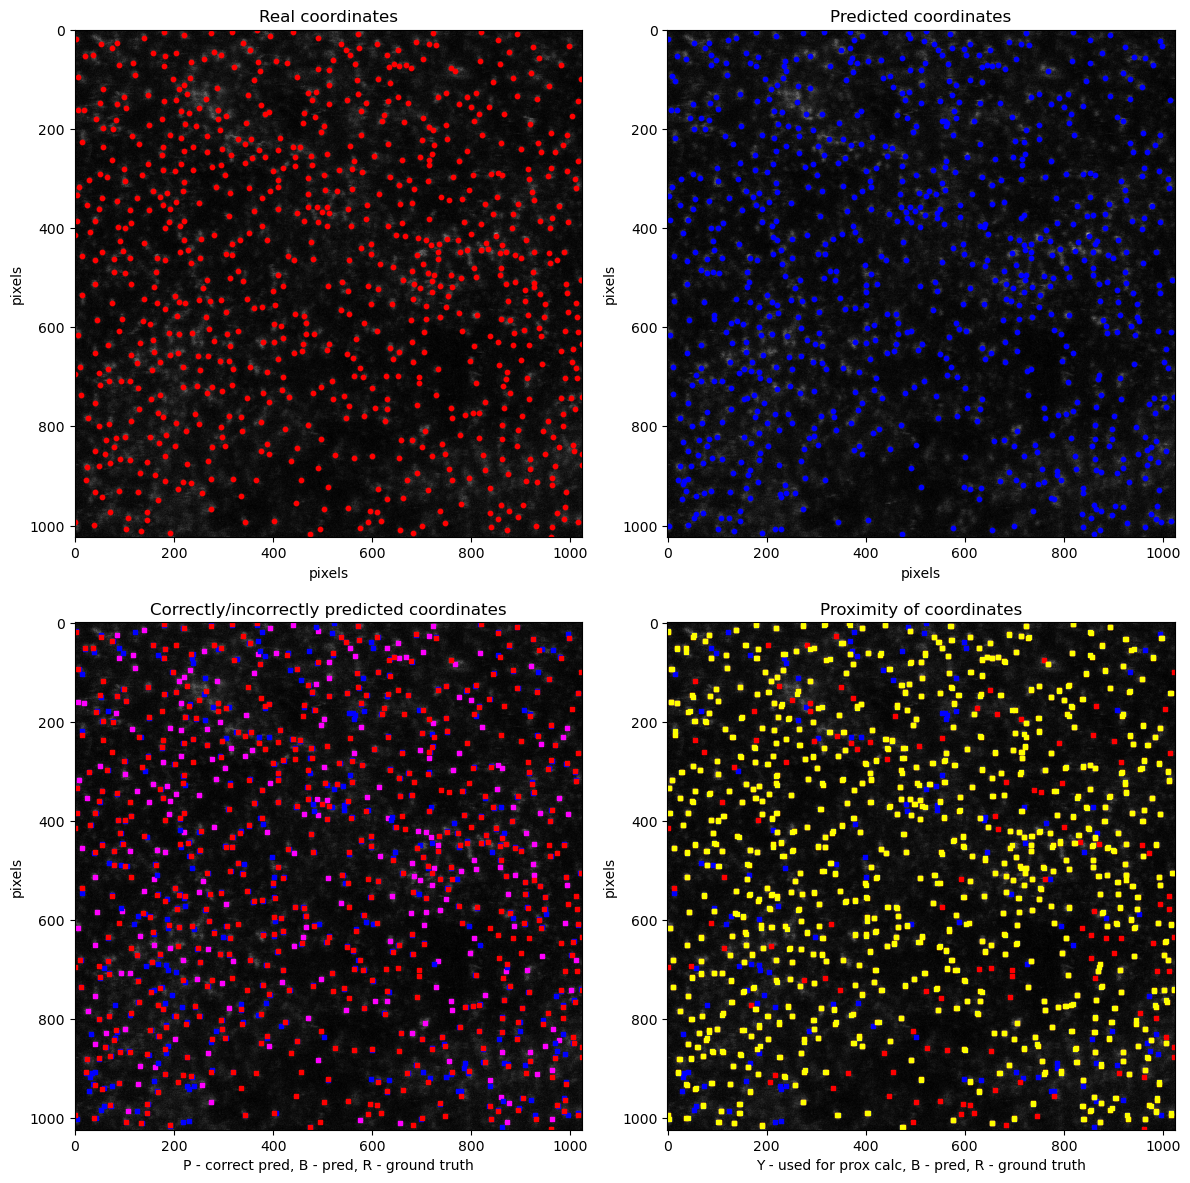

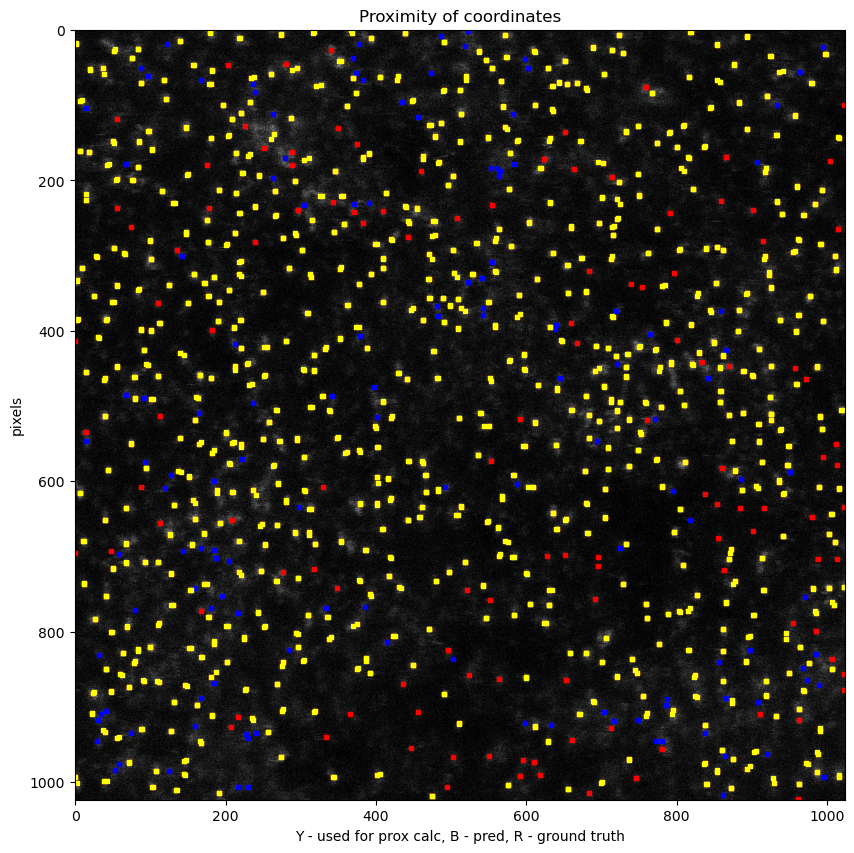

In [ ]:
# Sliding window parameters
window_size = 6 # Pixels squared
stride = 1 # no. of pixels the window moves between iterations

# Coordinate supression
distance_threshold = 5  # px (clouding)
min_samples = 50 # Minimum no. of predicted atoms for making a cloud ig
distance_weight = 0.3
brightness_weight = 0.7

max_dist_for_same_atom = 10 # px (precision rating)


##################################################################################


# Load the full-size micrograph
full_image_path = '/home/uku/desktop/ML-C/Pt_data/Pt_data/full_micrograph_w_labels/Pt-SAC-HX_0007.png'

full_image = Image.open(full_image_path) # Open the full image
full_image = np.array(full_image) / 255.0  # Normalize pixel values


# Initialize lists to store coordinates of detected metal atoms
detected_coordinates = []

# Convert the full image to a PyTorch tensor
full_image_tensor = torch.tensor(full_image, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions




# Slide the window across the image
for y in range(0, full_image.shape[0] - window_size + 1, stride):   # Iterates over the rows (from up to down) of the image with "0" and "full_image.shape[0] - window_size + 1" as the upper and lower boundaries
                                                                    # full_image.shape[0] - total height of the full pic (1024 px)
                                                                    # window_size - height of the window
    for x in range(0, full_image.shape[1] - window_size + 1, stride):               # Iterates over the columns (from left to right) of the image with "0" and "full_image.shape[1] - window_size + 1" as the upper and lower boundaries
        patch = full_image_tensor[:, :, y:y+window_size, x:x+window_size]           # Extracts a 21x21 patch from the image tensor at the current position
                                                                                    # Two colons (:) keep all dimensions for batch and channel (since the tensor has been expanded to include these dimensions)
                                                                                    # "y:y+window_size" selects the rows from y to y + window_size (extracts a vertical slice of the image)

                                                # Predict using the trained model
        model.eval()                            # Sets the model to evaluation mode, (necessary for making predictions)
        with torch.no_grad():                   # Disables gradient calculation (not needed for inference and saves memory)
            output = model(patch)               # The extracted patch is passed through the trained model to
            prediction = output.round().item()  # Extract the prediction as a scalar value
        if prediction == 1.0:                   # See if a metal atom is detected

            # Find coordinates within the patch
            atom_coords_in_patch = find_atom_coordinates(patch)
            # Adjust coordinates to the full image
            for (px, py) in atom_coords_in_patch:
                detected_coordinates.append((x + px, y + py))

detected_coordinates_before_supression = detected_coordinates

print("Amount of detected coordiates before supression: ", len(detected_coordinates))


#################### SUPRESSION OF EXTRA COORDINATES START ####################
detected_coordinates = distance_or_brightness_based_supression(detected_coordinates, distance_threshold, full_image_tensor, min_samples, distance_weight, brightness_weight)

print("Amount of detected coords after supression: ", len(detected_coordinates))
detected_coordinates = sorted(detected_coordinates, key=lambda x: x[0]) # Sort the list of tuples in ascending order by the first element of each tuple
#################### SUPRESSION OF EXTRA COORDINATES END   ####################


# Load ground truth coordinates
csv_file = '/home/uku/desktop/ML-C/Pt_data/Pt_data/full_micrograph_w_labels/Pt-SAC-HX_0007.csv'
ground_truth_coordinates = preprocess_full_micrograph_csv(csv_file)


# Convert the g-t array to a list of tuples with standard integers
ground_truth_coordinates = [(int(coord[0]), int(coord[1])) for coord in ground_truth_coordinates]


# Convert ground truth coordinates to a list of tuples
ground_truth_coordinates_tuples = [tuple(coord) for coord in ground_truth_coordinates]


#print('Actual coordinates: ', ground_truth_coordinates)
print("Amount of ground truth coordinates: ", len(ground_truth_coordinates))


# Convert lists of tuples to sets
detected_set = set(detected_coordinates)
ground_truth_set = set(ground_truth_coordinates_tuples)
detected_coordinates_before_supression_set = set(detected_coordinates_before_supression)


# Find common tuples before supression
common_tuples_before_supression = detected_coordinates_before_supression_set.intersection(ground_truth_set)
common_tuples_before_supression = list(common_tuples_before_supression)  # Convert the result back to a list if needed
# print("Correctly predicted before supression:", common_tuples_before_supression)
print("Amount correctly predicted before supression: ", len(common_tuples_before_supression))


# Find common tuples
common_tuples = detected_set.intersection(ground_truth_set)
common_tuples = list(common_tuples)  # Convert the result back to a list if needed
# print("Correctly predicted after supression:", common_tuples)
print("Amount correctly predicted after supression: ", len(common_tuples))
# print("Window size: ", window_size, "BW: ", brightness_weight, "DW: ", distance_weight)


# Create a list of predicted coordinates that were incorrect
incorrect_predictions = detected_set.symmetric_difference(common_tuples)


# Create a list of ground truth coordinates that were not predicted
not_found = ground_truth_set.symmetric_difference(common_tuples)


# Calculate distances between each ground truth coordinate and the closest detected coordinate within x pixels.
distances = []
used_ground_truth_coordinates = []
used_detected_coordinates = []

for gt in ground_truth_coordinates:
    min_distance = float('inf')
    closest_det = None
    for det in detected_coordinates:
        distance = euclidean_distance(gt, det)
        if distance < max_dist_for_same_atom and distance < min_distance:
            min_distance = distance
            closest_det = det
    if min_distance != float('inf'):
        distances.append(min_distance)
        used_ground_truth_coordinates.append(gt)
        used_detected_coordinates.append(closest_det)

# Calculate the average distance
if distances:
    average_distance = np.mean(distances)
else:
    average_distance = None


# Calculate the average distance
average_distance = np.mean(distances)


print("Amount of correct predictions if assuming, that prediction is correct when distance between pred. and g-t. is max 10 px.:", len(distances))
print(f"Average distance: {average_distance:.2f} pixels.")



############################# PLOTTING #############################

# Create a figure with three subplots side by side
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 12))

# Real coordinates
ax1.imshow(full_image, cmap='gray')
for coord in ground_truth_coordinates:
    ax1.scatter(coord[0], coord[1], color='red', s=10)
ax1.set_title('Real coordinates')
ax1.set_xlabel("pixels")
ax1.set_ylabel("pixels")

# Predicted coordinates
ax2.imshow(full_image, cmap='gray')
for coord in detected_coordinates:
    ax2.scatter(coord[0], coord[1], color='blue', s=10)
ax2.set_title('Predicted coordinates')
ax2.set_xlabel("pixels")
ax2.set_ylabel("pixels")

# Correctly predicted coordinates
ax3.imshow(full_image, cmap='gray')
for coord in common_tuples: # plot correctly predicted
    ax3.scatter(coord[0], coord[1], color='magenta', s=5, marker = "s")
for coord in incorrect_predictions: # plot incorrectly predicted
    ax3.scatter(coord[0], coord[1], color='blue', s=5,  marker = "s")
for coord in not_found: # plot not predicted real coordinates
    ax3.scatter(coord[0], coord[1], color='red', s=5, marker = "s")
ax3.set_title('Correctly/incorrectly predicted coordinates')
ax3.set_xlabel("P - correct pred, B - pred, R - ground truth")
ax3.set_ylabel("pixels")
ax3.legend

# Mark the coordinates mentioned in the proximity calc. as yellow and leave all the rest as is
ax4.imshow(full_image, cmap='gray')
for coord in common_tuples: # plot correctly predicted
    ax4.scatter(coord[0], coord[1], color='magenta', s=5, marker = "s")
for coord in incorrect_predictions: # plot incorrectly predicted
    ax4.scatter(coord[0], coord[1], color='blue', s=5,  marker = "s")
for coord in not_found: # plot not predicted real coordinates
    ax4.scatter(coord[0], coord[1], color='red', s=5, marker = "s")
for coord in used_detected_coordinates: # plot not predicted real coordinates
    ax4.scatter(coord[0], coord[1], color='yellow', s=5, marker = "s")
for coord in used_ground_truth_coordinates: # plot not predicted real coordinates
    ax4.scatter(coord[0], coord[1], color='yellow', s=5, marker = "s")
ax4.set_title('Proximity of coordinates')
ax4.set_xlabel("Y - used for prox calc, B - pred, R - ground truth")
ax4.set_ylabel("pixels")
ax4.legend

plt.tight_layout() # Adjust layout to prevent overlap
# plt.savefig('plots.png')
plt.show()




# Same as last but a bit bigger plot
plt.figure(figsize=(10, 10))
plt.imshow(full_image, cmap='gray')
for coord in common_tuples:  # plot correctly predicted
    plt.scatter(coord[0], coord[1], color='magenta', s=5, marker="s")
for coord in incorrect_predictions:  # plot incorrectly predicted
    plt.scatter(coord[0], coord[1], color='blue', s=5, marker="s")
for coord in not_found:  # plot not predicted real coordinates
    plt.scatter(coord[0], coord[1], color='red', s=5, marker="s")
for coord in used_detected_coordinates:  # plot used detected coordinates
    plt.scatter(coord[0], coord[1], color='yellow', s=5, marker="s")
for coord in used_ground_truth_coordinates:  # plot used ground truth coordinates
    plt.scatter(coord[0], coord[1], color='yellow', s=5, marker="s")
plt.title('Proximity of coordinates')
plt.xlabel("Y - used for prox calc, B - pred, R - ground truth")
plt.ylabel("pixels")
# plt.savefig('proximity_of_coordinates.png')
plt.show()

Evaluation:

In [30]:
# Assuming y_true are the actual labels and y_pred are the predicted labels
y_true = ground_truth_coordinates_tuples  # Actual labels
d_pred = detected_coordinates  # Predicted labels
u_pred = used_detected_coordinates

print(f"Part of predictions correct:  {(len(u_pred) / len(d_pred)*100):.1f} %")
print(f"Amount of correct positions found: {(len(u_pred) / len(y_true)*100):.1f} %")

Part of predictions correct:  83.4 %
Amount of correct positions found: 84.8 %
